In [1]:
#Importing all necessary libraries 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Data before preprocessing
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [9]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [10]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"needn't", 'same', 't', 'ourselves', 'below', "mightn't", 'what', 'here', 'his', 'they', 'there', 'an', 'too', "doesn't", 'wouldn', 'are', 'mightn', "mustn't", 'own', 'a', 'again', 'now', 'couldn', 'me', 'until', 'because', 'when', 'all', 'each', 'their', 'were', 'about', 'have', "should've", 'doing', 'further', 'you', "that'll", 'these', 'myself', "aren't", 'ours', 'once', 'that', 'such', 'doesn', "you'd", 'he', "shan't", 'and', 'hers', 'by', 'i', 'our', 'your', 'y', 'only', "hasn't", "couldn't", 'who', 'do', 'any', 'than', 'most', 'not', 'yourself', 'yourselves', 'won', 'himself', 'has', 'had', 'haven', 'him', 'under', 'wasn', 'been', 'at', 'should', "wasn't", 'this', 'mustn', 'd', 'after', 'hadn', "shouldn't", 'against', 'will', "you've", 'other', "wouldn't", 'of', 'then', 'which', 'needn', "didn't", 'or', 're', 'she', 'shan', 'her', 'o', 'few', "you'll", 'through', 'can', 'into', "hadn't", 'before', 'but', 'as', 'we', "isn't", 'my', 'didn', 'in', 'ma', "weren't", 'off', 'very', 'd

In [196]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final_data['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [12]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# BOW conversion and applying t-sne

In [66]:
#Taking 2000 positive and negative points

positive_2000 = final[final['Score'] == 1].sample(n=2000)
negative_2000 = final[final['Score'] == 0].sample(n=2000)

final_data = pd.concat([positive_2000, negative_2000])


In [231]:
count_Vectors = CountVectorizer()
bow_Vectors = count_Vectors.fit_transform(final_data['CleanedText'].values)
print("Type of bow_Vectors: ", type(bow_Vectors))
print("Shape of bow_Vectors: ", bow_Vectors.get_shape())

Type of bow_Vectors:  <class 'scipy.sparse.csr.csr_matrix'>
Shape of bow_Vectors:  (4000, 8875)


In [232]:
#1 and 0 are replaced with poitive and negative to make it type compatible

bow_final = final_data['Score']
bow_final =bow_final .replace({1:'positive', 0:'negative'})

In [233]:
#Converting sparse matrix to dense matrix as its required to eliminate empty cells
bow_dense = bow_Vectors.toarray()

In [234]:
#B a modPreparingl with perplexity=40 and iterations= 5000
#Using MulticoreTSNE as its speeds up the execution with more cores than normal tsne
from MulticoreTSNE import MulticoreTSNE as tsne1 
model_bow_dense = tsne1(n_components=2, perplexity=40, n_iter= 5000,\
                        random_state=0, n_jobs=2)
bow_tsne = model_bow_dense.fit_transform(bow_dense)

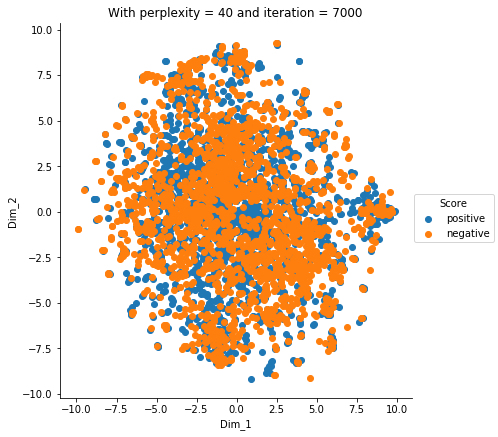

In [71]:
# Initialising a new data frame 
bow_tsne = np.vstack((bow_tsne.T, bow_final)).T

bow_tsne_fn = pd.DataFrame(data=bow_tsne, columns=("Dim_1", \
                                                   "Dim_2", "Score"))
# Ploting the result of tsne
sns.FacetGrid(bow_tsne_fn, hue="Score", size=6).map(plt.scatter, \
                                                    'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40 and iteration = 7000')
plt.show()

# TFIDF conversion and tsne representation

In [28]:
#Taking here only 1k positive reviews and 1k negative reviews

positive_1000 = final[final['Score'] == 1].sample(n=1000)
negative_1000 = final[final['Score'] == 0].sample(n=1000)
tfidf_data = pd.concat([positive_1000, negative_1000])



In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(tfidf_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 65153)
the number of unique words including both unigrams and bigrams  65153


In [30]:
#replacing the score of 1 with positive and 0 with negative

n_2000 = tfidf_data['Score']
n_2000 = n_2000.replace({1:'positive', 0:'negative'})

In [31]:
tfidf_dense = final_tf_idf.toarray()

In [25]:
#Building a model with perplexity=40 and iterations= 5000
from MulticoreTSNE import MulticoreTSNE as tsne1 
model_tfidf_dense = tsne1(n_components=2, perplexity=40, n_iter= 5000,\
                        random_state=0, n_jobs=2)
tsne_tfidf = model_tfidf_dense.fit_transform(tfidf_dense)

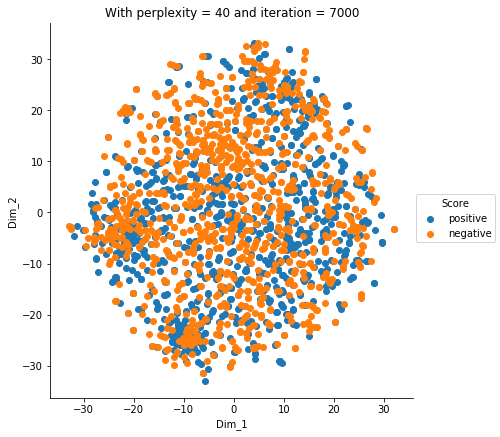

In [26]:
# Initialising a new data frame 
tsne_tfidf = np.vstack((tsne_tfidf.T,n_2000)).T

tsne_tfidf = pd.DataFrame(data=tsne_tfidf, columns=("Dim_1", \
                                                   "Dim_2", "Score"))
# Ploting the result of tsne
sns.FacetGrid(tsne_tfidf, hue="Score", size=6).map(plt.scatter, \
                                                    'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40 and iteration = 7000')
plt.show()

# AVG-Word2vec with less datapoints

In [179]:
#Taking 2000 positive and negative points

positive_2000 = final[final['Score'] == 1].sample(n=2000)
negative_2000 = final[final['Score'] == 0].sample(n=2000)

final_set = pd.concat([positive_2000, negative_2000])

In [180]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_set['CleanedText'].values:
    list_of_sent.append(sent.split())

In [181]:
print(final_set['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

two dog niec absolut crazi chef michael especi beef version tenderloin porterhous etc two get mix dri food treat touch hot water make nice gravi food found easier order amazon pet food store carri ship fast definit conveni
*****************************************************************
['two', 'dog', 'niec', 'absolut', 'crazi', 'chef', 'michael', 'especi', 'beef', 'version', 'tenderloin', 'porterhous', 'etc', 'two', 'get', 'mix', 'dri', 'food', 'treat', 'touch', 'hot', 'water', 'make', 'nice', 'gravi', 'food', 'found', 'easier', 'order', 'amazon', 'pet', 'food', 'store', 'carri', 'ship', 'fast', 'definit', 'conveni']


In [182]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [183]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2950
sample words  ['two', 'dog', 'absolut', 'crazi', 'chef', 'michael', 'especi', 'beef', 'version', 'etc', 'get', 'mix', 'dri', 'food', 'treat', 'touch', 'hot', 'water', 'make', 'nice', 'gravi', 'found', 'easier', 'order', 'amazon', 'pet', 'store', 'carri', 'ship', 'fast', 'definit', 'conveni', 'love', 'moka', 'pot', 'keep', 'espresso', 'habit', 'inexpens', 'cost', 'valu', 'stumbl', 'type', 'illi', 'made', 'grind', 'youd', 'find', 'real', 'machin']


In [184]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 711.52it/s]


4000
50


In [185]:
#Converting to stack matrix
avgw2v_np = np.vstack(sent_vectors)

In [227]:
avgw2v_np.shape

(4000, 50)

In [228]:
#converting the Score 1 to positive and 0 to negative
w_2000 = final_set['Score']
w_2000 = score.replace({1:'positive', 0:'negative'})

In [229]:
from MulticoreTSNE import MulticoreTSNE as tsne1 
model = tsne1(n_components=2, perplexity=50, n_iter= 2000, \
              random_state=0, n_jobs=1)
tsne_avgw2v = model.fit_transform(avgw2v_np)

In [236]:
# Initialising a new data frame 
tsne_avgw2v = np.vstack((tsne_avgw2v.T, w_2000)).T
tsne_avgw2v_fn = pd.DataFrame(data=tsne_avgw2v, columns=("Dim_1", \
                                                         "Dim_2", "Score"))

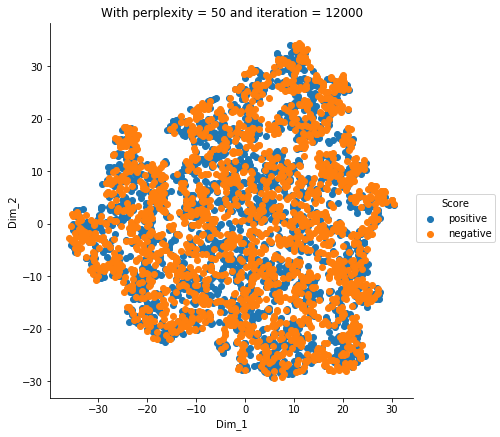

In [237]:
# Ploting the result of tsne
sns.FacetGrid(tsne_avgw2v_fn, hue="Score", size=6).map(plt.scatter, \
                                                       'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 and iteration = 12000')
plt.show()

# TF-IDF word2vec using own dataset

In [211]:
#Taking 2000 positive and negative points

positive_2000 = final[final['Score'] == 1].sample(n=2000)
negative_2000 = final[final['Score'] == 0].sample(n=2000)

final_set = pd.concat([positive_2000, negative_2000])

In [212]:
i=0
list_of_sent=[]
for sent in final_set['CleanedText'].values:
    list_of_sent.append(sent.split())

In [213]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [214]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2938
sample words  ['set', 'four', 'bag', 'cereal', 'come', 'sturdi', 'carton', 'hold', 'good', 'storag', 'use', 'mix', 'ingredi', 'bread', 'most', 'eat', 'hot', 'make', 'week', 'breakfast', 'super', 'nutrit', 'easi', 'much', 'better', 'price', 'get', 'groceri', 'store', 'complet', 'satisfi', 'arriv', 'time', 'less', 'expens', 'amazon', 'assum', 'even', 'find', 'coffe', 'cant', 'last', 'powder', 'egg', 'sever', 'decad', 'ago', 'well', 'order', 'put']


In [215]:
#defining the tfidfVectorizer
model_tfidf = TfidfVectorizer()
tf_idf_matrix = model_tfidf.fit_transform(final_set['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_tfidf.get_feature_names(), list(model_tfidf.idf_)))

In [216]:

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 569.44it/s]


In [218]:
tfidf_w2v = np.vstack(tfidf_sent_vectors)
tfidf_w2v.shape

(4000, 50)

In [223]:
model_tfidf_tsne = tsne1(n_components=2, perplexity=40, n_iter=3000, n_jobs=1)
tsne_tfidfw2v = model_tfidf_tsne.fit_transform(tfidf_w2v)

In [225]:
# Initialising a new data frame 
tsne_tfidfw2v = np.vstack((tsne_tfidfw2v.T, w_2000)).T
tsne_tfidfw2v_fn = pd.DataFrame(data=tsne_tfidfw2v, columns=("Dim_1", "Dim_2", "Score"))

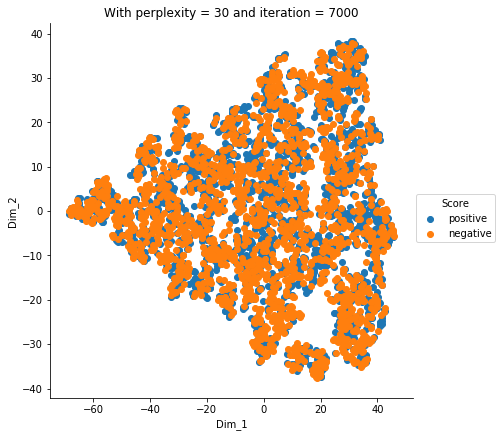

In [226]:
# Ploting the result of tsne
sns.FacetGrid(tsne_tfidfw2v_fn, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30 and iteration = 7000')
plt.show()